The codes have commented the ones thta applying the simple classifiers, as LR and NB, to the datasets with the pretrained word embeddings.

In [61]:

import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import transformers
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import seaborn as sns
import torch
import gensim
from gensim.models import Word2Vec


[nltk_data] Downloading package punkt to /home/amber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/amber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/amber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [62]:
df_train= pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/data/TRAIN/old/labeled_10k.csv', encoding='cp1252')
df_test=pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/data/TEST/labeled_17k.csv', encoding='cp1252')

In [63]:
# WORD-COUNT
df_train['word_count'] = df_train['moment'].apply(lambda x: len(str(x).split()))


##Data Cleaning

In [64]:
# Transfer the string to numeric data
df_train['agency'] = df_train['agency'].map({'yes': 1, 'no': 0})
df_train['social'] = df_train['social'].map({'yes': 1, 'no': 0})

df_test['agency'] = df_test['agency'].map({'yes': 1, 'no': 0})
df_test['social'] = df_test['social'].map({'yes': 1, 'no': 0})

df_train.head()

,hmid,moment,concepts,agency,social,age,country,gender,married,parenthood,reflection,word_count
0,27674,I was happy when my son got 90% marks in his e...,education|family,0,1,29.0,IND,m,married,y,24h,12
1,27685,went to movies with my friends it was fun,entertainment,1,1,29.0,IND,m,single,y,24h,9
2,27691,A hot kiss with my girl friend last night made...,romance,1,1,25.0,IND,m,married,y,24h,12
3,27701,My son woke me up to a fantastic breakfast of ...,family|food,0,1,79,USA,f,widowed,y,24h,17
4,27712,My older daughter keeps patting my younger dau...,family,0,1,30,USA,f,married,y,24h,9


In [65]:
# convert the original data to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

# Lexicon - based
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer

# #2. STEMMING
# # Initialize the stemmer
# snow = SnowballStemmer('english')
# def stemming(string):
#     a=[snow.stem(i) for i in word_tokenize(string) ]
#     return " ".join(a)

# 3.
wl = WordNetLemmatizer()
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [66]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['moment'].apply(lambda x: finalpreprocess(x))
df_train.head()

df_test['clean_text'] = df_test['moment'].apply(lambda x: finalpreprocess(x))
df_test.head()

,hmid,moment,reflection,age,country,gender,duration,married,parenthood,concepts,agency,social,clean_text
0,0,I was able to spend the day with my fiance sho...,24h,28,USA,m,all_day_im_still_feeling_it,single,n,shopping|family|romance,1,0,able spend day fiance shopping yesterday
1,1,I was able to play with my cat.,24h,28,USA,m,at_least_one_hour,single,n,animals,1,0,able play cat
2,2,I was able to clean my room and gold my laundry.,24h,28,USA,m,at_least_one_hour,single,n,0,1,0,able clean room gold laundry
3,3,I spend the day at a party on the beach and I ...,24h,24,USA,m,half_a_day,single,n,vacation|party|weather,1,1,spend day party beach happy see friend miss be...
4,4,My cat greeting me when I got home from work -...,24h,24,USA,m,half_a_day,single,n,animals,0,0,cat greet get home work sweet cute loving


TRAIN TEST SPLITTING OF LABELLED DATASET

In [67]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
#X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["agency"],test_size=0.2,shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["agency"],test_size=0.2,shuffle=True)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(df_train["clean_text"], df_train["social"],test_size=0.2,shuffle=True)
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(df_train["clean_text"],pd.DataFrame({'agency':df_train["agency"],'social':df_train["social"]}),test_size=0.2,shuffle=True)
# print(y_train_s)
#print(len(X_train), len(y_train))


3). Logistic Regression with Word2Vec

Tokenized with Bert

In [68]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=512)


In [69]:
# Concatenate train data and test data
all_text = np.concatenate([df_train.moment.values, df_test.moment.values])
# Encode our concatenated data
encoded_text = [tokenizer.encode(i, add_special_tokens=True) for i in all_text]
#print(encoded_text)
embed_vocab = {}
for word in tokenizer.vocab.keys():
    embed_vocab[word] = True
print(len(embed_vocab))
# Find the maximum length
max_len = max([len(i) for i in encoded_text])
print('Max length: ', max_len)

30522
Max length:  155


In [70]:
text = df_train['clean_text']
text_words = []
text_vocab = {}
for string in text:
    # Don't include words that can't actually be mapped to a vector using embeddings
    words = string.split()
    filtered_words = []
    for word in words:
        text_vocab[word] = True
        if embed_vocab.get(word) is not None:
            filtered_words.append(word)
    text_words.append(filtered_words)

In [71]:
# print(text_words)

In [72]:
def vocab_coverage(compared, base):  #, k):
    hit, miss = 0, 0
    for word in compared:
        if base.get(word) is not None:
            hit += 1
        else:
            miss += 1
            #base[word] = np.random.uniform(-0.25, 0.25, k)
    print("{} words were found".format(hit))
    print("{} words weren't found".format(miss))
    #print("new length of {} word_vectors".format(len(embed_vocab)))

vocab_coverage(text_vocab, embed_vocab)  # , 300)

4544 words were found
1391 words weren't found


In [73]:
def preprocessing_data(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    MAX_LEN = 128

    # For every sentence...
    for i in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = i ,  # Preprocess sentence
            add_special_tokens=False,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=False      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))

    # # Convert lists to tensors
    # input_ids = torch.tensor(input_ids)
    # attention_masks = torch.tensor(attention_masks)

    return input_ids



In [74]:
#prepare input under agency/sociality/combined class
train_inputs = preprocessing_data(X_train)
val_inputs = preprocessing_data(X_val)

train_inputs_s = preprocessing_data(X_train_s)
val_inputs_s = preprocessing_data(X_val_s)

train_inputs_m = preprocessing_data(X_train_m)
val_inputs_m = preprocessing_data(X_val_m)




In [75]:
test_inputs = preprocessing_data(df_test['clean_text'])

Basic classifiers under Bert tokenizer

In [76]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
print(type(y_train))

datasets = {
    'train_a': TensorDataset(torch.tensor(train_inputs), torch.tensor(y_train.values)),
    'val_a': TensorDataset(torch.tensor(val_inputs),  torch.tensor(y_val.values)),
    'train_s': TensorDataset(torch.tensor(train_inputs_s),  torch.tensor(y_train_s.values)),
    'val_s': TensorDataset(torch.tensor(val_inputs_s),  torch.tensor(y_val_s.values)),
    'test': TensorDataset(torch.tensor(test_inputs),  torch.tensor(df_test['social'].values)),

}
print(datasets['train_a'])
dataloaders = {
    'train_a': DataLoader(datasets['train_a'], batch_size=batch_size),
    'val_a': DataLoader(datasets['val_a'], batch_size=batch_size),
    'train_s': DataLoader(datasets['train_s'], batch_size=batch_size),
    'val_s': DataLoader(datasets['val_s'], batch_size=batch_size),
    'test': DataLoader(datasets['test'], batch_size=batch_size),
}

<class 'pandas.core.series.Series'>


2. [30 marks] Train an advanced classifier based on deep learning, such as fine-tuning BERT. You can try predicting both labels independently, or in a multi-task manner. Use part of the training data for validation, and keep aside the test data when choosing the best model.


In [77]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")


running on the GPU


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                          embedding_dim=self.embed_dim,
                                          padding_idx=0,
                                          max_norm=5.0)
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(0, 2, 1)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]

        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list],
                         dim=1)

        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits


In [79]:
import torch.optim as optim
from transformers import AdamW
def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=5e-5):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.1)

    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)
    optimizer = AdamW(cnn_model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
    # Instantiate Adadelta optimizer
    # optimizer = optim.Adadelta(cnn_model.parameters(),
    #                            lr=learning_rate,
    #                            rho=0.95)

    return cnn_model, optimizer


In [80]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    """Train the CNN model."""

    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        t0_epoch = time.time()
        total_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy

            time_elapsed = time.time() - t0_epoch
            print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy


In [81]:
# CNN training
set_seed(42)
cnn, optimizer = initilize_model(vocab_size=len(embed_vocab),
                                      embed_dim=300,
                                      learning_rate=0.001,
                                      dropout=0.1)
train(cnn, optimizer, dataloaders['train_a'], dataloaders['val_a'], epochs=20)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.593139   |  0.564251  |   73.34   |   1.58   
   2    |   0.532069   |  0.534442  |   73.86   |   1.54   
   3    |   0.490541   |  0.505256  |   75.38   |   1.57   
   4    |   0.449413   |  0.479815  |   77.46   |   1.54   
   5    |   0.410737   |  0.461056  |   78.36   |   1.59   
   6    |   0.375050   |  0.448150  |   79.40   |   1.56   
   7    |   0.343196   |  0.439217  |   79.59   |   1.57   
   8    |   0.314619   |  0.433326  |   79.83   |   1.55   
   9    |   0.286759   |  0.429180  |   79.64   |   1.55   
  10    |   0.260573   |  0.426809  |   79.73   |   1.60   
  11    |   0.236882   |  0.425556  |   79.78   |   1.55   
  12    |   0.214899   |  0.425236  |   80.07   |   1.57   
  13    |   0.193307   |  0.426425  |   80.35   |   1.56   
  14    |   0.175016   |  0.427790  |   80.30   |   1.58   
  15    |   0.157038

In [82]:
# torch.cuda.memory_stats()

In [83]:
import torch.nn.functional as F

def predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []


    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [84]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [85]:
torch.cuda.empty_cache()

AUC: 0.8399
Accuracy: 80.11%


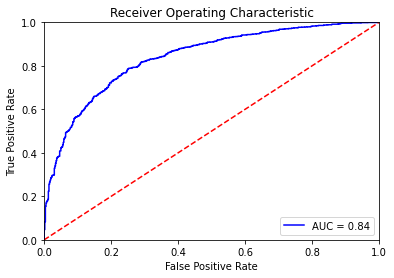

              precision    recall  f1-score   support

           0       0.51      0.66      0.58       435
           1       0.91      0.84      0.87      1677

    accuracy                           0.80      2112
   macro avg       0.71      0.75      0.72      2112
weighted avg       0.82      0.80      0.81      2112



In [86]:
probs_val = predict(cnn, dataloaders['val_a'])

# Evaluate the Bert classifier
evaluate_roc(probs_val, y_val)
# Get predictions from the probabilities
threshold = 0.5
preds_val = np.where(probs_val[:, 1] > threshold, 1, 0)

print(classification_report(preds_val, y_val ))

AUC: 0.7970
Accuracy: 77.08%


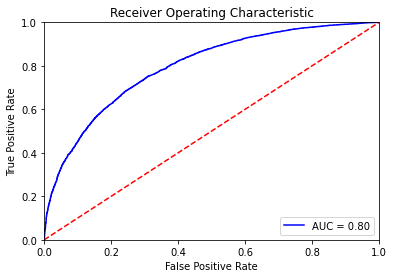

              precision    recall  f1-score   support

           0       0.48      0.65      0.55      3710
           1       0.89      0.80      0.85     13505

    accuracy                           0.77     17215
   macro avg       0.68      0.73      0.70     17215
weighted avg       0.80      0.77      0.78     17215



In [87]:
# Compute predicted probabilities on the test set
probs_test = predict(cnn, dataloaders['test'])

# Get predictions from the probabilities
threshold = 0.5
preds_test = np.where(probs_test[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
#print("Number of tweets predicted non-negative: ", preds_test.sum())

# Evaluate the Bert classifier
evaluate_roc(probs_test, df_test['agency'] )
print(classification_report(preds_test, df_test['agency'] ))

In [88]:
# For sociality
# CNN-rand: Word vectors are randomly initialized.
set_seed(42)
cnn_s, optimizer = initilize_model(vocab_size=len(embed_vocab),
                                      embed_dim=300,
                                      learning_rate=0.001,
                                      dropout=0.1)
train(cnn_s, optimizer, dataloaders['train_s'], dataloaders['val_s'], epochs=20)


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.648334   |  0.604778  |   67.38   |   1.56   
   2    |   0.551593   |  0.518208  |   77.08   |   1.56   
   3    |   0.457769   |  0.443427  |   80.87   |   1.60   
   4    |   0.376761   |  0.388246  |   84.00   |   1.55   
   5    |   0.313183   |  0.352104  |   85.70   |   1.58   
   6    |   0.266262   |  0.329667  |   86.46   |   1.56   
   7    |   0.230782   |  0.315667  |   87.22   |   1.57   
   8    |   0.201157   |  0.306894  |   87.69   |   1.61   
   9    |   0.176901   |  0.301215  |   87.97   |   1.56   
  10    |   0.156121   |  0.297981  |   88.16   |   1.59   
  11    |   0.137728   |  0.296307  |   88.12   |   1.56   
  12    |   0.121807   |  0.296067  |   88.21   |   1.59   
  13    |   0.107531   |  0.296518  |   88.49   |   1.58   
  14    |   0.094692   |  0.297623  |   88.54   |   1.57   
  15    |   0.083155

AUC: 0.9465
Accuracy: 88.26%


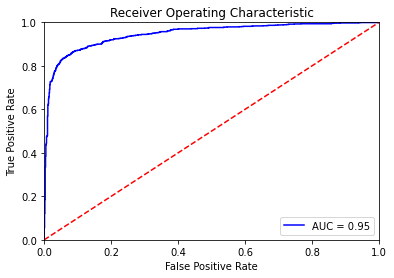

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1040
           1       0.87      0.90      0.89      1072

    accuracy                           0.88      2112
   macro avg       0.88      0.88      0.88      2112
weighted avg       0.88      0.88      0.88      2112



In [89]:
probs_val_s = predict(cnn_s,  dataloaders['val_s'])

# Evaluate the Bert classifier
evaluate_roc(probs_val_s, y_val_s)
# Get predictions from the probabilities
threshold = 0.5
preds_val_s = np.where(probs_val_s[:, 1] > threshold, 1, 0)

print(classification_report(preds_val_s, y_val_s ))


AUC: 0.9403
Accuracy: 87.45%


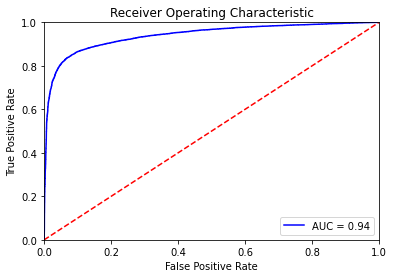

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      7503
           1       0.89      0.89      0.89      9712

    accuracy                           0.87     17215
   macro avg       0.87      0.87      0.87     17215
weighted avg       0.87      0.87      0.87     17215



In [90]:
# Compute predicted probabilities on the test set
probs_test_s = predict(cnn_s, dataloaders['test'])
# Evaluate the Bert classifier
evaluate_roc(probs_test_s, df_test['social'] )
# Get predictions from the probabilities
preds_test_s = np.where(probs_test_s[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
# print("Number of tweets predicted non-negative: ", preds_test_s.sum())


print(classification_report(preds_test_s, df_test['social'] ))

In [91]:
output = df_test[preds_test==1]
list(output.sample(20).moment)

['The day I stepped on the scale and my weight finally reached my goal.',
 'I did a perler beads craft night with my best friend.',
 'I wrote a great new song on the guitar after not feeling creative for a while.',
 'Last week I took a chance on going to a networking happy hour and met many new contacts and potentially one day friends.',
 'I saw my old friends at the village and talked about childhood memories.',
 'My husband and I visited southern California and watched the sun set as we ate dinner at a restaurant on the beach.',
 'My younger daughter started trying to walk on her own last week.',
 'I found a free drawing app in the Play store, and it turned out to be better than a paid app I was considering buying.',
 'I completed a half marathon row last night.',
 'I saved up enough money to buy some snacks online.',
 'I bought a scratch ticket and won a small amount of money.',
 'Finding a good quality TV to buy at a good price made me really happy.',
 'I was able to spend some tim

In [92]:
output_s = df_test[preds_test_s==1]
list(output_s.sample(20).moment)

["I went to an event at the library celebrating Harry Potter's birthday and I won two prizes from the raffle!",
 'All of my kids went to sleep and I got some peace and quiet',
 'The day my younger brother graduated with his law degree.',
 'When my baby slept through the night, a few weeks ago, and I got a good nights sleep, two nights in a row.',
 'I went out to dinner with my mom.',
 'I did provided salary appraisal for my employees',
 'my friends are arranged with one wonderful trip so i have good plan with new dress and fancy foods are taken my bag the this trip was very interested and joyful so i feel very happy to the moment',
 'Thinking about my brother in law when he was still alive.',
 'I canned seven quarts of peas without losing a single jar in the pressure cooker.',
 'Have an appointment with my girlfriend all day',
 'My old friend contacted me out of the blue and offered me a money-making opportunity.',
 'The day I got a promotion is an unforgettable moment in my life.',
 '